# Central Differential Privacy (Server-Side Clipping)





**Central Differential Privacy (DP) with Server-Side Clipping** applies two steps:

1. **Clip client updates**
2. **Add noise to the aggregated model**

This approach ensures uniform clipping across clients and reduces communication overhead, but increases server-side computation.

For this, Flower provides DP wrappers around strategies like `FedAvg`. In our case, we use:

### ViT: `DifferentialPrivacyServerSideAdaptiveClipping`

This strategy **dynamically adjusts the clipping norm** during training based on the updates received. It helps balance privacy and utility more effectively than fixed clipping.

> We focus our experiments on this adaptive clipping approach.

---

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [ ]:
import os
import sys
sys.path.append("../..")

import ray
import time

from transformers import ViTForImageClassification

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping, FedAvg
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights

from src.tracker import reset_base_memory_csv

In [ ]:
# Replace with appropritate values

data_name_ = 'alzheimer' #"skin_lesions" #
base_type_ = "ViT"           
exp_name_ = "CDP-SA"
num_labels_ = 4
experiment_name_ = ExperimentName.FL_CDP_SA_VIT

In [ ]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name= exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

In [ ]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name = data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn)

In [ ]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )
    
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    # Wrap the strategy with the DifferentialPrivacyServerSideFixedClipping wrapper
    dp_strategy = DifferentialPrivacyServerSideAdaptiveClipping(
        strategy= strategy,
        noise_multiplier = 0.1,
        num_sampled_clients = fed_config.get("num_clients"),
        initial_clipping_norm = 0.1,
        target_clipped_quantile= 0.1,
        clip_norm_lr = 0.2,
        clipped_count_stddev= fed_config.get("num_clients")/20
        )
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = dp_strategy, config = sever_config)

# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [6]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-06 16:12:06,052	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-06 16:12:06,536	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-06 16:12:07,139	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_a5ef9aa7ed3cf371.zip' (17.41MiB) to Ray cluster...
2025-05-06 16:12:07,194	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_a5ef9aa7ed3cf371.zip'.
2025-05-06 16:12:08,395 - DEBUG - Asyncio event loop already running.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by str

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 2 minutes 35 seconds


(ClientAppActor pid=29089) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
(ClientAppActor pid=29089)   df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
(ClientAppActor pid=29089) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=29089) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=29089) Seed set to 42
(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-lin

(ClientAppActor pid=29090) 
(ClientAppActor pid=29090) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29090) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29090) ⏱️ Total training time: 4 minutes 41 seconds


(raylet) [2025-05-06 16:17:26,240 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 809984000; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:17:36,248 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 809971712; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:17:46,257 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 809938944; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:17:56,267 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 3 minutes 57 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
(raylet) [2025-05-06 16:19:16,336 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 808927232; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: central DP noise with 0.0030 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.1

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 3 minutes 30 seconds


(raylet) [2025-05-06 16:23:36,568 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 806432768; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=29089) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=29089) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=29089) Seed set to 42
(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29089) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=29089)   self.pid = os.fork()
(raylet) [

(ClientAppActor pid=29090) 
(ClientAppActor pid=29090) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29090) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29090) ⏱️ Total training time: 5 minutes 13 seconds


(raylet) [2025-05-06 16:25:26,669 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 804745216; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:25:36,677 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 804626432; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:25:46,687 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 804548608; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:25:56,696 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 3 minutes 31 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0845.
INFO :      aggregate_fit: parameters are clipped by value: 0.0845.
INFO :      aggregate_fit: parameters are clipped by value: 0.0845.
INFO :      aggregate_fit: central DP noise with 0.0025 stdev added
(raylet) [2025-05-06 16:27:16,770 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 802885632; capacity: 52589998080. Object creation will fail if spilling is required.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.1

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 3 minutes 55 seconds


(raylet) [2025-05-06 16:31:57,020 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 799252480; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=29089) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=29089) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=29089) Seed set to 42
(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29089) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=29089)   self.pid = os.fork()
(raylet) [

(ClientAppActor pid=29090) 
(ClientAppActor pid=29090) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29090) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29090) ⏱️ Total training time: 5 minutes 26 seconds


(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29089) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=29089)   self.pid = os.fork()
(raylet) [2025-05-06 16:33:37,108 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 797650944; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:33:47,116 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 797634560; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:33:57,125 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_20

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 3 minutes 1 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0706.
INFO :      aggregate_fit: parameters are clipped by value: 0.0706.
INFO :      aggregate_fit: parameters are clipped by value: 0.0706.
INFO :      aggregate_fit: central DP noise with 0.0021 stdev added
(raylet) [2025-05-06 16:35:07,186 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 796581888; capacity: 52589998080. Object creation will fail if spilling is required.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.1

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 4 minutes 25 seconds


(ClientAppActor pid=29089) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=29089) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=29089) Seed set to 42
(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29089) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=29089)   self.pid = os.fork()
(raylet) [2025-05-06 16:40:27,464 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 791683072; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [

(ClientAppActor pid=29090) 
(ClientAppActor pid=29090) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29090) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29090) ⏱️ Total training time: 5 minutes 20 seconds


(raylet) [2025-05-06 16:41:17,509 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 790900736; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:41:27,517 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 790827008; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:41:37,527 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 790810624; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:41:47,536 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 2 minutes 44 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0592.
INFO :      aggregate_fit: parameters are clipped by value: 0.0592.
(raylet) [2025-05-06 16:43:07,607 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 789696512; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: parameters are clipped by value: 0.0592.
INFO :      aggregate_fit: central DP noise with 0.0018 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.1

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT)
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv
(ClientAppActor pid=29089) ⏱️ Total training time: 2 minutes 37 seconds


(ClientAppActor pid=29089) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=29089) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=29090) 


(ClientAppActor pid=29089) Seed set to 42
(ClientAppActor pid=29089) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29089) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=29089)   self.pid = os.fork()
(raylet) [2025-05-06 16:46:37,796 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 787288064; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:46:47,806 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 787279872; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 16:46:57,816 E 27179 27214] (raylet) file_system_monitor.cc:111: /h

(ClientAppActor pid=29089) 
(ClientAppActor pid=29089) 🔎 Tracker: FL + CDP-SA (ViT) [repeated 2x across cluster]
(ClientAppActor pid=29089) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SA_ViT/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=29089) ⏱️ Total training time: 2 minutes 36 seconds [repeated 2x across cluster]


(raylet) [2025-05-06 16:49:07,935 E 27179 27214] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_16-12-03_946997_20173 is over 95% full, available space: 786030592; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0502.
INFO :      aggregate_fit: parameters are clipped by value: 0.0502.
INFO :      aggregate_fit: parameters are clipped by value: 0.0502.
INFO :      aggregate_fit: central DP noise with 0.0015 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.1


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SA_VIT Model Final Evaluation 

Test Accuracy: 4.14% | Precision: 0.12 | Recall: 0.04 | F1-Score: 0.05 | ROC-AUC: 0.45 | MCC: -0.01
 


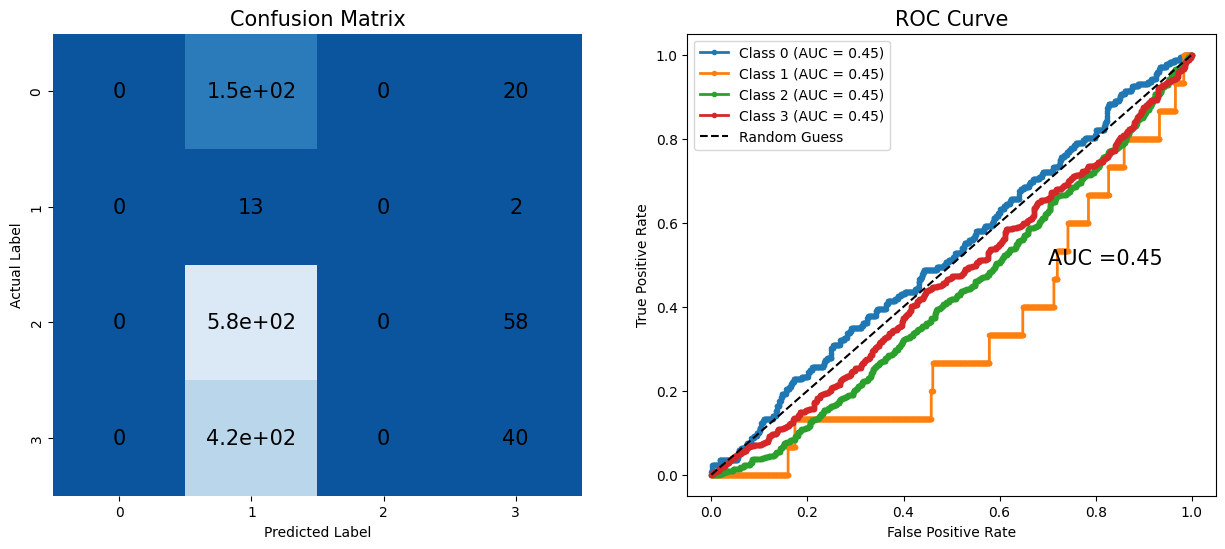


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SA_VIT Model Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.01      0.87      0.02        15
           2       0.00      0.00      0.00       634
           3       0.33      0.09      0.14       459

    accuracy                           0.04      1280
   macro avg       0.09      0.24      0.04      1280
weighted avg       0.12      0.04      0.05      1280

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 3510.96 sec
✅ Total Energy: 0.15392 kWh
🌍 Total CO₂ Emitted: 0.06618 kg
🧠 Peak CPU RAM: 0.00 GB
🖥️ Peak GPU VRAM: 5.96 GB

 ___________________________________________________________________________________________________


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


🕒 Total Time: 37 min 47 sec


In [ ]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()